In [1]:
#basic essential libraries
import pandas as pd
import numpy as np
import string
from math import sqrt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.arima_model import ARIMA

#to ignore warning messages
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

In [2]:
#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#set visual parameters
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 10,6

In [38]:
PATH = "C:/Users/kpunyakoti/Desktop/Future/Flix/Data/fullsets/"
PATH2 = "C:/Users/kpunyakoti/Desktop/Future/Flix/Data/"

In [53]:
train = pd.read_csv(f'{PATH}train_full.csv')
test = pd.read_csv(f'{PATH}sub.csv')
dp = pd.read_csv(f'{PATH2}datapoint.csv')

In [56]:
cols_str = ['country_1', 'channel_id']
for x in cols_str:
    train[x] = train[x].astype(str)
    test[x] = test[x].astype(str)
    dp[x] = dp[x].astype(str)

In [57]:
train['cc'] = train.country_1+'_'+train.channel_id
test['cc'] = test.country_1+'_'+test.channel_id
dp['cc'] = dp.country_1+'_'+dp.channel_id

In [58]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [59]:
actual_test = test.copy()

In [60]:
test['tickets'] = np.nan

In [61]:
cc_minor = dp.loc[dp['rowcount']<25, 'cc']

In [62]:
for i in cc_minor.values:
    test.loc[test['cc'] == i, 'tickets'] = 0

In [63]:
cc_major = dp.loc[~dp.cc.isin(cc_minor.values), 'cc']

In [64]:
test.head()

,date,country_1,channel_id,cc,tickets
0,2018-02-27,1,1,1_1,0.0
1,2018-02-27,1,13,1_13,0.0
2,2018-02-27,1,17,1_17,0.0
3,2018-02-27,1,2,1_2,0.0
4,2018-02-27,1,23,1_23,0.0


In [65]:
print(len(cc_minor.values))
print(len(cc_major.values))

605
207


#### Run from here safely

In [66]:
new_train = train.loc[train.cc.isin(cc_major.values)]
new_test = test.loc[test.cc.isin(cc_major.values)]

In [67]:
forecast_dates = new_test.date.unique()

In [68]:
new_test.head()

,date,country_1,channel_id,cc,tickets
9,2018-02-27,1,28,1_28,NaN
15,2018-02-27,1,35,1_35,NaN
17,2018-02-27,1,37,1_37,NaN
19,2018-02-27,1,39,1_39,NaN
29,2018-02-27,11,1,11_1,NaN


## Forecast Loop

In [70]:
def blackmamba(cc, train):
    tf = train.loc[train.cc == cc, ['date','tickets']]
    tf.sort_values('date', inplace=True)
    tf.set_index('date', inplace=True)
    
    df_logscale = np.log1p(tf) #log transformation for stationarity 
    
    dflogshift = df_logscale - df_logscale.shift() #one shift of logvalues for better statiotionarity
    dflogshift.dropna(inplace=True)
    
    results = arima_tune(df_logscale, dflogshift.tickets) #call timeseries model to get the best model after tuning
    
    best_pqd = min(results, key = results.get)
    best_rss, best_model = results.get(best_pqd)
    
    preds_array = best_model.forecast(steps = 22, alpha = 0.05)[0]
    final_preds = np.round(np.expm1(preds_array))
    
    return final_preds

In [71]:
def arima_tune(logscale, logshift):
    results = {}
    for AR in range(0,8):
        for MA in range(0,8):
            model = ARIMA(logscale, order = (AR,1,MA))
            fit_is_available = False
            results_ARIMA = None
            try:
                results_ARIMA = model.fit(disp = -1, method = 'css')
                fit_is_available = True
            except:
                continue
            if fit_is_available:
                RSS = get_rss(logshift, results_ARIMA.fittedvalues)
                results['%d-1-%d' % (AR,MA)]=[RSS, results_ARIMA]
    return results

In [69]:
def get_rss(series, fits):
    fits_new = fits  
    missing_idx = list(set(series.index).difference(set(fits_new.index)))
    if missing_idx:
        nan_series = pd.Series(index = pd.to_datetime(missing_idx))
        fits_new = fits_new.append(nan_series)
        fits_new.sort_index(inplace = True)
        fits_new.fillna(method = 'bfill', inplace = True) 
        fits_new.fillna(method = 'ffill', inplace = True)
    return sum((fits_new - series)**2)

In [ ]:
counter = 207
for cc in cc_major.values:
    print('Forecasting cc: {}'.format(cc))
    print(counter, ' left')
    preds = blackmamba(cc,new_train)
    
    i = 0
    for d in forecast_dates:
        new_test.loc[((new_test.date == d)&(new_test.cc==cc)), 'tickets'] = preds[i]
        i+=1    
    counter -=1

### Submission

In [78]:
store_file = new_test.copy()

In [101]:
def submission(new_test):
    new_test['tickets'] =new_test['tickets'].astype(int)
    new_test['tickets'] =new_test['tickets'].astype(str)
    
    test.tickets.fillna(0, inplace=True)
    test['tickets'] = test['tickets'].astype(int)
    
    final_submission = pd.merge(test, new_test, how = 'left', on = ['date', 'country_1', 'channel_id', 'cc'])
    final_submission.tickets_y.fillna(0, inplace=True)

    final_submission['tickets_y'] = final_submission['tickets_y'].astype(int)
    final_submission['tickets'] = final_submission.tickets_x+final_submission.tickets_y
    
    final_submission.drop(['tickets_x','tickets_y', 'cc'], axis = 1, inplace= True)
    
    return final_submission

In [102]:
submission = submission(new_test)

In [104]:
submission.to_csv(f'{PATH}final_sub.csv')

### CC_Metrics

In [105]:
def cc_met(cc, train):
    tf = train.loc[train.cc == cc, ['date','tickets']]
    tf.sort_values('date', inplace=True)
    tf.set_index('date', inplace=True)
    
    df_logscale = np.log1p(tf)
    
    dflogshift = df_logscale - df_logscale.shift()
    dflogshift.dropna(inplace=True)
    
    best_pdq, best_rss = cc_arima(df_logscale, dflogshift.tickets)
    
    return best_pdq, best_rss

In [106]:
def cc_arima(logscale, logshift):
    results = {}
    for AR in range(0,8):
        for MA in range(0,8):
            model = ARIMA(logscale, order = (AR,1,MA))
            fit_is_available = False
            results_ARIMA = None
            try:
                results_ARIMA = model.fit(disp = -1, method = 'css')
                fit_is_available = True
            except:
                continue
            if fit_is_available:
                RSS = get_RSS(logshift, results_ARIMA.fittedvalues)
                results['%d-1-%d' % (AR,MA)]=[RSS, results_ARIMA]
    best_pdq = min(results, key = results.get)
    best_rss, best_model = results.get(best_pdq)
    
    return best_pdq, best_rss

In [ ]:
df_cols = ['country', 'channel', 'best_p-d-q', 'best_RSS']
cc_metrics_full = pd.DataFrame(columns=df_cols)
row_index=0
for cc in cc_major.values:
    country, channel = cc.split('_')
    pdq, rss = cc_met(cc,new_train)
    
    cc_metrics_full.loc[row_index, 'country'] = country
    cc_metrics_full.loc[row_index, 'channel'] = channel
    cc_metrics_full.loc[row_index, 'best_p-d-q'] = pdq
    cc_metrics_full.loc[row_index, 'best_RSS'] = rss
       
    row_index +=1
    print(row_index,'|', country,'|', channel,'|', pdq,'|', rss)

In [108]:
cc_metrics_full.head()

,country,channel,best_p-d-q,best_RSS
0,20,26,1-1-4,44.7099
1,20,28,2-1-5,146.68
2,20,29,4-1-5,21.1295
3,20,31,6-1-3,82.8488
4,20,35,4-1-6,195.592


In [109]:
cc_metrics_full.to_csv(f'{PATH}cc_metrics_full.csv')

In [118]:
pc = train.loc[((train.country_1 == '12')& (train.channel_id=='37')),['date','tickets']]

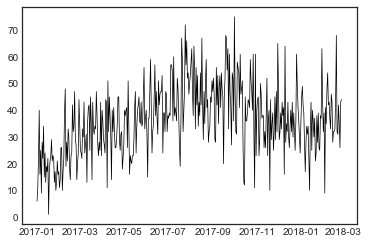

In [129]:
plt.plot(pc.date, pc.tickets,'-', color='black', linewidth = 0.7)